In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import librosa as lb
import librosa.display
import keras
import IPython.display as ipd

%matplotlib inline

#### **Loading in our Data**
We do this by mounting our local drive for the audio files and loading our pre-processed .csv files

In [ ]:
# mount local drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# import csv files
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv
Saving val.csv to val.csv


In [ ]:
train = pd.read_csv('train.csv')
val = pd.read_csv('val.csv')

In [ ]:
train.head()    # training set (our files had already been split using train_test_split in the pre-processing stage)

,Unnamed: 0,pid,filename,disease
0,2562,151,151_2p3_Lr_mc_AKGC417L_4.wav,COPD
1,2536,151,151_2p2_Tc_mc_AKGC417L_2.wav,COPD
2,6893,226,226_1b1_Pl_sc_LittC2SE_5.wav,Pneumonia
3,5089,191,191_2b1_Pr_mc_LittC2SE_0.wav,Pneumonia
4,1897,138,138_1p2_Pl_mc_AKGC417L_3.wav,COPD


In [ ]:
val.head()    # validation set

,Unnamed: 0,pid,filename,disease
0,2287,146,146_8p3_Ar_mc_AKGC417L_7.wav,COPD
1,653,115,115_1b1_Ar_sc_Meditron_5.wav,LRTI
2,1853,136,136_1b1_Ar_sc_Meditron_5.wav,Healthy
3,4408,176,176_2b3_Ll_mc_AKGC417L_3.wav,COPD
4,2706,154,154_1b3_Ll_mc_AKGC417L_0.wav,COPD


##### **Let's view the distribution of our Diagnoses**

Unfortunately, the data is heavily skewed with the vast majority of diagnoses being COPD

(array([   0., 1000., 2000., 3000., 4000., 5000.]),
 <a list of 6 Text major ticklabel objects>)

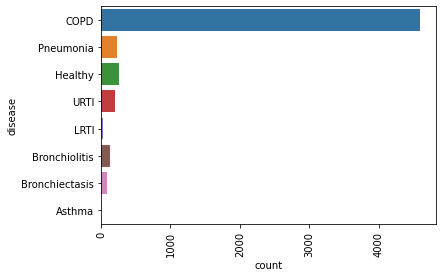

In [ ]:
sns.countplot(y=train.disease)
plt.xticks(rotation=90)

## **Inspecting an Individual Audio Track**

We'll load a sample from our data set and inspect it in order to gain a better understanding of audio feature generation.

During pre-processing, we already cut our wav files down to 6 second intervals for uniformity. 

In [ ]:
example = '/content/gdrive/My Drive/processed_audio_files/101_1b1_Al_sc_Meditron_0.wav'                                  # load in an individual wav file
x, freq = librosa.load(example)

In [ ]:
sr = freq    # saving frequency into a sample rate variable

In [ ]:
print(x.shape)   # array of amplitudes
print(type(x))
print(freq)      # sampling rate 22050Hz
print(type(freq))

(132300,)
<class 'numpy.ndarray'>
22050
<class 'int'>


In [ ]:
ipd.Audio(example)   # Listen 

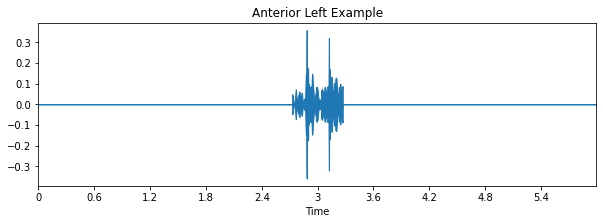

In [ ]:
plt.figure(figsize=(10,3))                               # plotting the waveform in time domain
plt.title('Anterior Left Example')


librosa.display.waveplot(x, sr=freq)

#### **Spectrogram**

Using short-term fourier transform on an example grabbed from the dataset of an Anterior Left recording

In [ ]:
X = librosa.stft(x)                                   # short-time fourier transform
X_db = librosa.amplitude_to_db(abs(X))

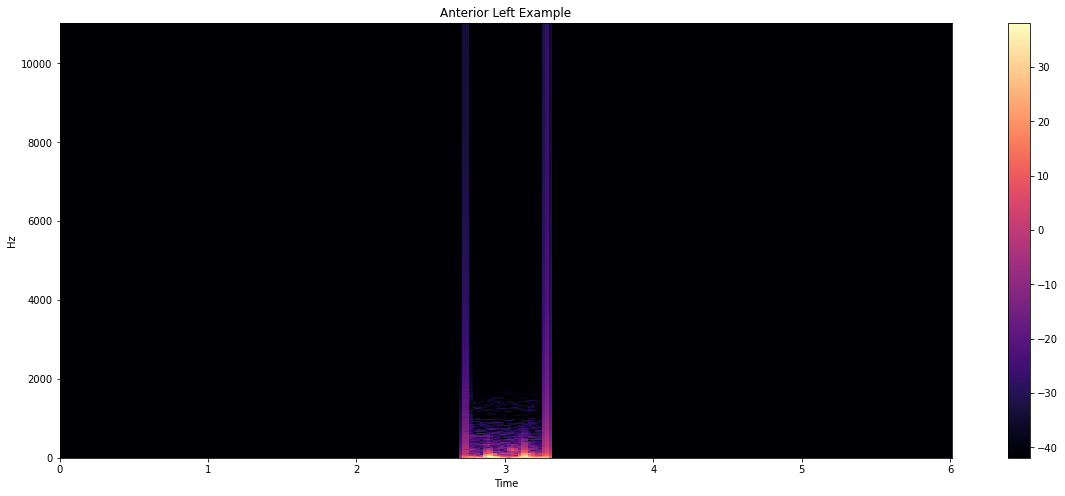

In [ ]:
plt.figure(figsize=(20, 8))
librosa.display.specshow(X_db, sr=sr, x_axis='time', y_axis='hz')
plt.title('Anterior Left Example')
plt.colorbar()

#### **Mel Frequency Cepstral Coefficients**

MFCC of the same example


Shape of mfcc:  (20, 259)


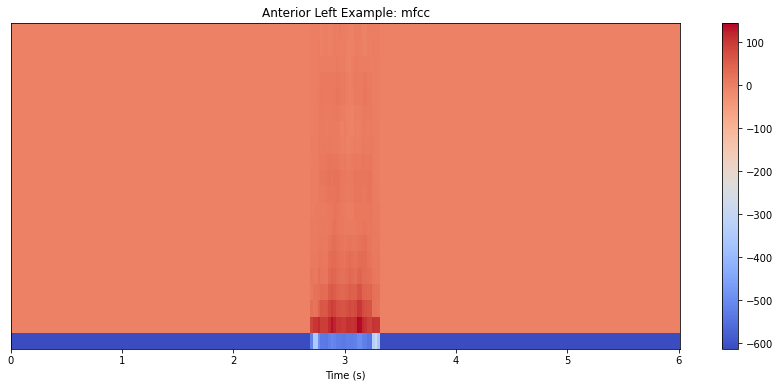

In [ ]:
# Mel Frequency Cepstral Coefficients

mfcc = lb.feature.mfcc(x, sr=sr)
print('Shape of mfcc: ', mfcc.shape)

plt.figure(figsize=(15, 6))
librosa.display.specshow(mfcc, x_axis='s')
plt.title('Anterior Left Example: mfcc')
plt.colorbar()

#### **Chroma Short Time Fourier Transform**

(12, 259)


/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


Text(0, 0.5, 'Hz')

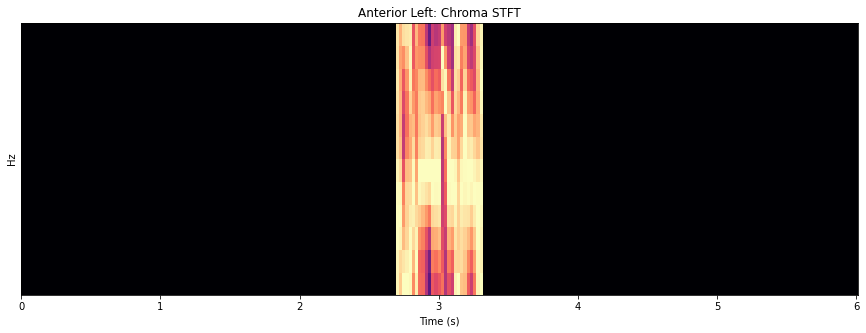

In [ ]:
chroma = lb.feature.chroma_stft(x)
print(chroma.shape)

plt.figure(figsize=(15, 5))
plt.title('Anterior Left: Chroma STFT')
librosa.display.specshow(chroma, x_axis='s')
plt.ylabel('Hz')

### **Melspectrogram**

(128, 259)


Text(0, 0.5, 'Hz')

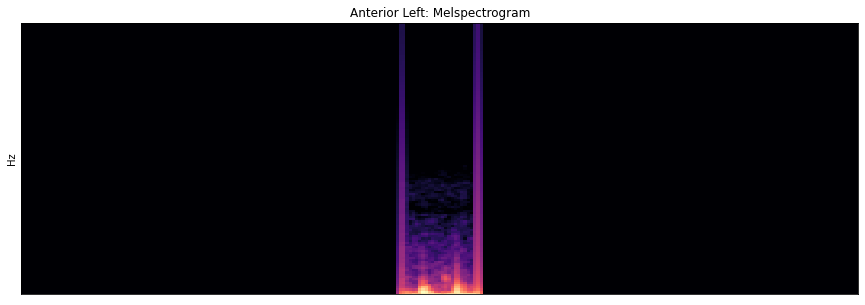

In [ ]:
mel_spec = lb.feature.melspectrogram(x)
print(mel_spec.shape)

plt.figure(figsize=(15, 5))
plt.title('Anterior Left: Melspectrogram')
librosa.display.specshow(librosa.power_to_db(mel_spec))
plt.ylabel('Hz')

## **Building Our Model**

##### **Label Encoding**

We'll grab the y labels of our train and validation sets to encode them. Strings won't work in our model.

In [ ]:
y_train = train['disease']
y_val = val['disease']

In [ ]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
ytrain=le.fit_transform(y_train)
yval=le.transform(y_val)

#### **Feature Extraction**

As we saw earlier, we will use the librosa library to extract our features. 
For this pass, our features will be MFCC, Chroma STFT, Melspectrogram.

We'll start by creating a function that grabs each of these features, then we'll iterate through our folder where the files are kept and call the function on each wav file. 

We'll keep the validation and training set separate. 


In [ ]:
def getFeatures2(path):
  soundArr, sample_rate = lb.load(path)
  spec_cent = lb.feature.spectral_centroid(y=soundArr, sr=sample_rate)
  spec_band = lb.feature.spectral_bandwidth(y=soundArr, sr=sample_rate)
  mfcc = lb.feature.mfcc(y=soundArr, sr=sample_rate)

  return spec_cent, cstft, mSpec

In [ ]:
root = '/content/gdrive/My Drive/processed_audio_files/'
spec_cent, spec_band, mfcc = [], [], []

for idx, row in val.iterrows():
  path = root + row['filename']
  a, b, c = getFeatures2(path)
  spec_cent.append(a)
  spec_band.append(b)
  mfcc.append(c)

spec_cent_val = np.array(spec_cent)
spec_band_val = np.array(spec_band)
mfcc_val = np.array(mfcc)

In [ ]:
root = '/content/gdrive/My Drive/processed_audio_files/'
spec_cent, spec_band, mfcc = [], [], []

for idx, row in train.iterrows():
  path = root + row['filename']
  a, b, c = getFeatures2(path)
  spec_cent.append(a)
  spec_band.append(b)
  mfcc.append(c)

spec_cent_train = np.array(spec_cent)
spec_cent_train = np.array(spec_band)
mfcc_train = np.array(mfcc)

In [ ]:
features_train_np = np.concatenate((
    spec_cent_train,
    spec_band_train,
    mfcc_train
)).T

In [ ]:
scaler = preprocessing.StandardScaler()
features_train_np = scaler.fit_transform(features_train_np)

In [ ]:
features_val_np = np.concatenate((
    spec_cent_val,
    spec_band_val,
    mfcc_val
)).T

## **Building our CNN**

In [ ]:
def getFeatures(path):
  soundArr, sample_rate = lb.load(path)
  mfcc = lb.feature.mfcc(y=soundArr, sr=sample_rate)
  cstft = lb.feature.chroma_stft(y=soundArr, sr=sample_rate)
  mSpec = lb.feature.melspectrogram(y=soundArr, sr = sample_rate)

  return mfcc, cstft, mSpec

In [ ]:
root = '/content/gdrive/My Drive/processed_audio_files/'
mfcc, cstft, mSpec = [],[],[]

for idx, row in val.iterrows():
  path = root + row['filename']
  a, b, c = getFeatures(path)
  mfcc.append(a)
  cstft.append(b)
  mSpec.append(c)

mfcc_val = np.array(mfcc)
cstft_val = np.array(cstft)
mSpec_val = np.array(mSpec)

/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [ ]:
root= '/content/gdrive/My Drive/processed_audio_files/'
mfcc,cstft,mSpec=[],[],[]

for idx,row in train.iterrows():
    path=root + row['filename']
    a,b,c =getFeatures(path)
    mfcc.append(a)
    cstft.append(b)
    mSpec.append(c)
    
mfcc_train=np.array(mfcc)
cstft_train=np.array(cstft)
mSpec_train=np.array(mSpec)

/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0.00001,mode='min')
]

In [ ]:
mfcc_input=keras.layers.Input(shape=(20,259,1),name="mfccInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(mfcc_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mfcc_output=keras.layers.GlobalMaxPooling2D()(x)

mfcc_model=keras.Model(mfcc_input, mfcc_output, name="mfccModel")

In [ ]:
mfcc_model.summary()

Model: "mfccModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mfccInput (InputLayer)      [(None, 20, 259, 1)]      0         
                                                                 
 conv2d_11 (Conv2D)          (None, 20, 87, 32)        832       
                                                                 
 batch_normalization_11 (Bat  (None, 20, 87, 32)       128       
 chNormalization)                                                
                                                                 
 activation_11 (Activation)  (None, 20, 87, 32)        0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 10, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 10, 22, 64)        18

In [ ]:
croma_input=keras.layers.Input(shape=(12,259,1),name="cromaInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(croma_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
croma_output=keras.layers.GlobalMaxPooling2D()(x)


In [ ]:
croma_model=keras.Model(croma_input, croma_output, name="cromaModel")

In [ ]:
croma_model.summary()

Model: "cromaModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cromaInput (InputLayer)     [(None, 12, 259, 1)]      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 12, 87, 32)        832       
                                                                 
 batch_normalization_4 (Batc  (None, 12, 87, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 12, 87, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 43, 32)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 6, 22, 64)         1

In [ ]:
mSpec_input=keras.layers.Input(shape=(128,259,1),name="mSpecInput")
x=keras.layers.Conv2D(32,5,strides=(2,3),padding='same')(mSpec_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(2,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mSpec_output=keras.layers.GlobalMaxPooling2D()(x)

mSpec_model=keras.Model(mSpec_input, mSpec_output, name="mSpecModel")

In [ ]:
mSpec_model.summary()

Model: "mSpecModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mSpecInput (InputLayer)     [(None, 128, 259, 1)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 87, 32)        832       
                                                                 
 batch_normalization_7 (Batc  (None, 64, 87, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 64, 87, 32)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 22, 64)        1

In [ ]:
input_mfcc=keras.layers.Input(shape=(20,259,1),name="mfcc")
mfcc=mfcc_model(input_mfcc)

input_croma=keras.layers.Input(shape=(12,259,1),name="croma")
croma=croma_model(input_croma)

input_mSpec=keras.layers.Input(shape=(128,259,1),name="mspec")
mSpec=mSpec_model(input_mSpec)


concat=keras.layers.concatenate([mfcc,croma,mSpec])
hidden=keras.layers.Dropout(0.2)(concat)
hidden=keras.layers.Dense(50,activation='relu')(concat)
hidden=keras.layers.Dropout(0.3)(hidden)
hidden=keras.layers.Dense(25,activation='relu')(hidden)
hidden=keras.layers.Dropout(0.3)(hidden)
output=keras.layers.Dense(8,activation='softmax')(hidden)

net=keras.Model([input_mfcc,input_croma,input_mSpec], output, name="Net")

In [ ]:
net.summary()

Model: "Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mfcc (InputLayer)              [(None, 20, 259, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 croma (InputLayer)             [(None, 12, 259, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 mspec (InputLayer)             [(None, 128, 259, 1  0           []                               
                                )]                                                              

In [ ]:
from keras import backend as K
net.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
K.set_value(net.optimizer.learning_rate, 0.001)

In [ ]:
y_val.head()

0       COPD
1       LRTI
2    Healthy
3       COPD
4       COPD
Name: disease, dtype: object

In [ ]:
history=net.fit(
    {"mfcc":mfcc_train,"croma":cstft_train,"mspec":mSpec_train},
    ytrain,
    validation_data=({"mfcc":mfcc_val,"croma":cstft_val,"mspec":mSpec_val},yval),
    epochs=100, verbose=0,
    callbacks=my_callbacks
    
)

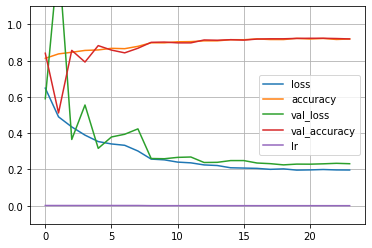

In [ ]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(-0.1,1.1)
plt.show()

In [ ]:
net.evaluate({"mfcc":mfcc_val,"croma":cstft_val,"mspec":mSpec_val},yval)

44/44 [==============================] - 4s 94ms/step - loss: 0.2315 - accuracy: 0.9203


[0.23154745995998383, 0.9202898740768433]